In [2]:
import pandas as pd 
## Load the dataset
df = pd.read_csv("C:/Users/SVMY/Downloads/University project github/univariate_final.csv")
df.head()

,Age,Greenland_temperature,Upper_band,Lower_band
0,-43.0,-30.54,-30.34,-30.74
1,-42.0,-30.61,-30.46,-30.76
2,-41.0,-30.72,-30.58,-30.86
3,-40.0,-30.85,-30.73,-30.97
4,-39.0,-31.02,-30.88,-31.16


In [3]:
## find th no of no of null values
sum(df.isnull()['Age'])

11

In [4]:
## remove Null values
series = df['Greenland_temperature'][:11200]
df.sort_index(inplace=True)

In [5]:
## show the dimmension of the dataset
series.shape

(11200,)

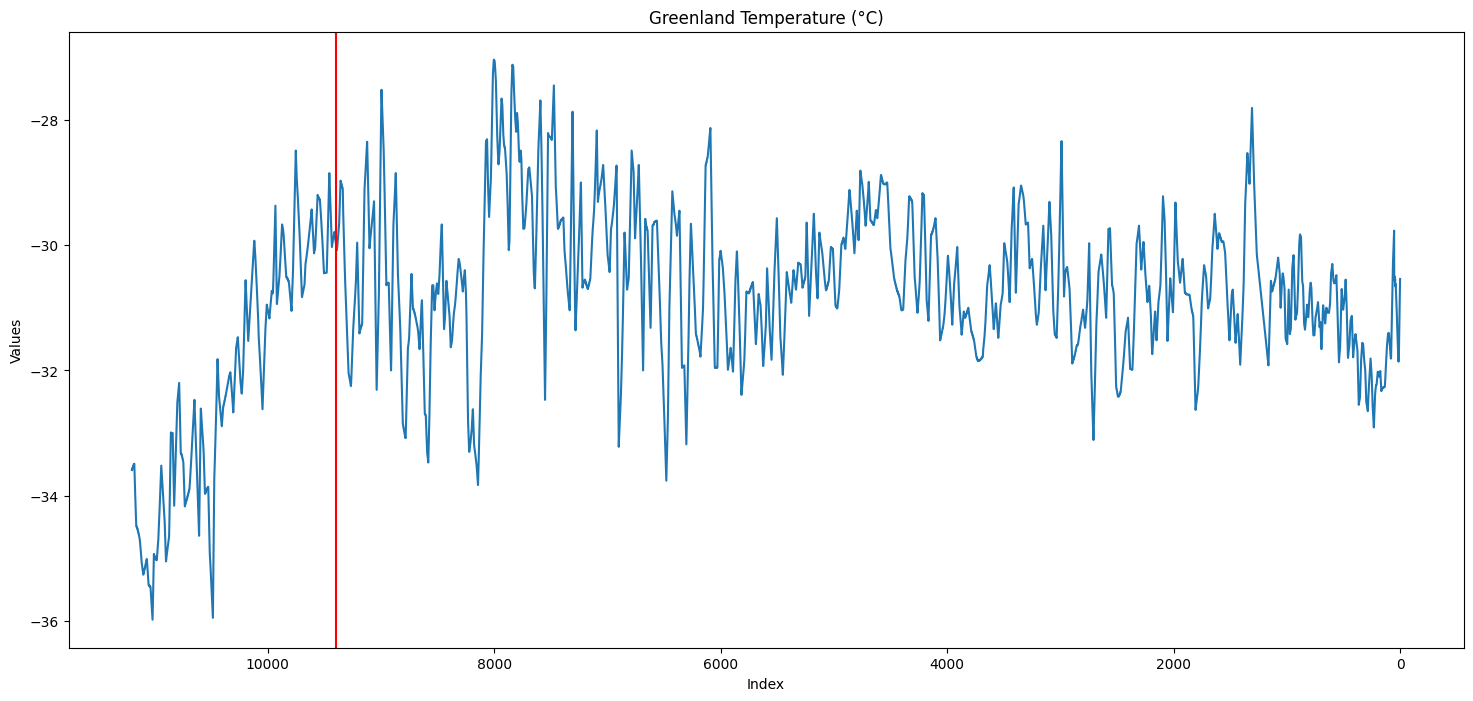

In [6]:
## Simple line plot
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.figure(figsize=(18,8))
plt.plot(series)
plt.gca().invert_xaxis()
plt.title("Greenland Temperature (°C)")
plt.ylabel("Values")
plt.xlabel("Index")
plt.axvline(x=9400, color='r')

# save plot
plt.savefig("image/univarite_lineplot1.svg")
plt.show()


In [1]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series,title='Greenland Temperature (°C)'):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [7]:
## perform ADF test
adf_test(series)

Augmented Dickey-Fuller Test: Greenland Temperature (°C)
ADF test statistic         -5.124652
p-value                     0.000013
# lags used                37.000000
# observations          11162.000000
critical value (1%)        -3.430936
critical value (5%)        -2.861799
critical value (10%)       -2.566908
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


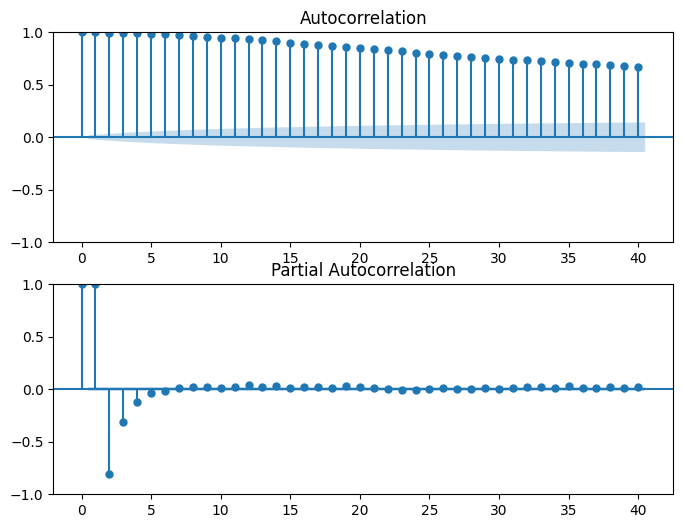

In [9]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Compute ACF and PACF
acf = sm.tsa.stattools.acf(series)
pacf = sm.tsa.stattools.pacf( series)
    
# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
sm.graphics.tsa.plot_acf(series, lags=40, ax=axes[0])

sm.graphics.tsa.plot_pacf(series, lags=40, ax=axes[1])
#plt.savefig("Final_figure/acf_pacf_test.svg")
plt.show()


In [11]:
## Split train and test dataset

t_value = int(len(series)*(80/100))
train= series[0:t_value]
test= series[t_value:]

In [12]:
## AR(2) Model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(2,0,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     Greenland_temperature   No. Observations:                 8960
Model:                    ARIMA(2, 0, 0)   Log Likelihood               22640.624
Date:                   Thu, 01 Jun 2023   AIC                         -45273.248
Time:                           08:50:36   BIC                         -45244.846
Sample:                                0   HQIC                        -45263.582
                                  - 8960                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.5777      0.139   -220.713      0.000     -30.849     -30.306
ar.L1          1.9155      0.001   1808.854      0.000       1.913       1.918
ar.L2         -0.9174      0.001   -855.178      0.000      -0.919      -0.915
sigma2         0.0004   5.04e-07    740.890      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                 169.41   Jarque-Bera (JB):         146119496.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                       628.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

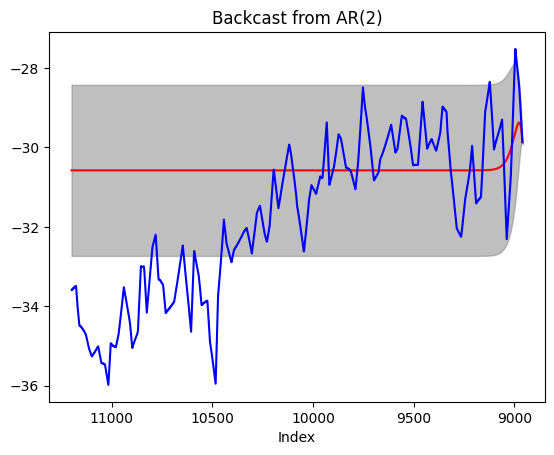

In [13]:
import statsmodels.api as sm
import statsmodels
model = sm.tsa.ARIMA(train, order=(2,0,0))
results = model.fit()
# In-sample one-step-ahead predictions
predict = results.get_prediction(start=len(train), end=11200)
predict_ci = predict.conf_int()
predict_dy = results.predict(start=len(train), end=11200)
plt.plot(predict_dy,color="red")
plt.plot(test,color='blue')
plt.title("Backcast from AR(2)")
plt.xlabel("Index")
plt.gca().invert_xaxis()
plt.fill_between(range(len(train),11200+1), predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha=0.5, color='gray', label='95% Confidence')
#plt.xlim([10200, 10300])
#plt.savefig("Final_figure/residual_AR(2)_test.svg")
plt.show()

In [14]:
# calculate aic
def calculate_aic(n, mse, num_params):
 aic = n * log(mse) + 2 * num_params
 return aic

def calculate_bic(n, mse, num_params):
 bic = n * log(mse) + num_params * log(n)
 return bic
range_ffd = len(test)-sum(test.isna())

In [17]:
from sklearn.metrics import mean_squared_error
from math import log
import math
from sklearn.metrics import r2_score

# calculate the error
mse = mean_squared_error(test[:range_ffd], predict_dy[:range_ffd])
print('MSE: %.3f' % mse)
# calculate the aic
aic = calculate_aic(len(test[:range_ffd]), mse,2)
print('AIC: %.3f' % aic)
# calculate the aic
bic = calculate_bic(len(test[:range_ffd]), mse,2)
print('BIC: %.3f' % bic)
# Return the square root 
print ('RMSE: %.3f' % math.sqrt(mse))
# Calculate R-squared predicted
r2_pred = r2_score(test[:range_ffd], predict_dy[:range_ffd])

print("R-squared:", round(r2_pred,2))

MSE: 5.197
AIC: 3695.518
BIC: 3706.947
RMSE: 2.280
R-squared: -0.36


In [18]:
## traning dataset for different percentage of actual dataset
percentage = [85,90,95,99] #traing dataset percentage

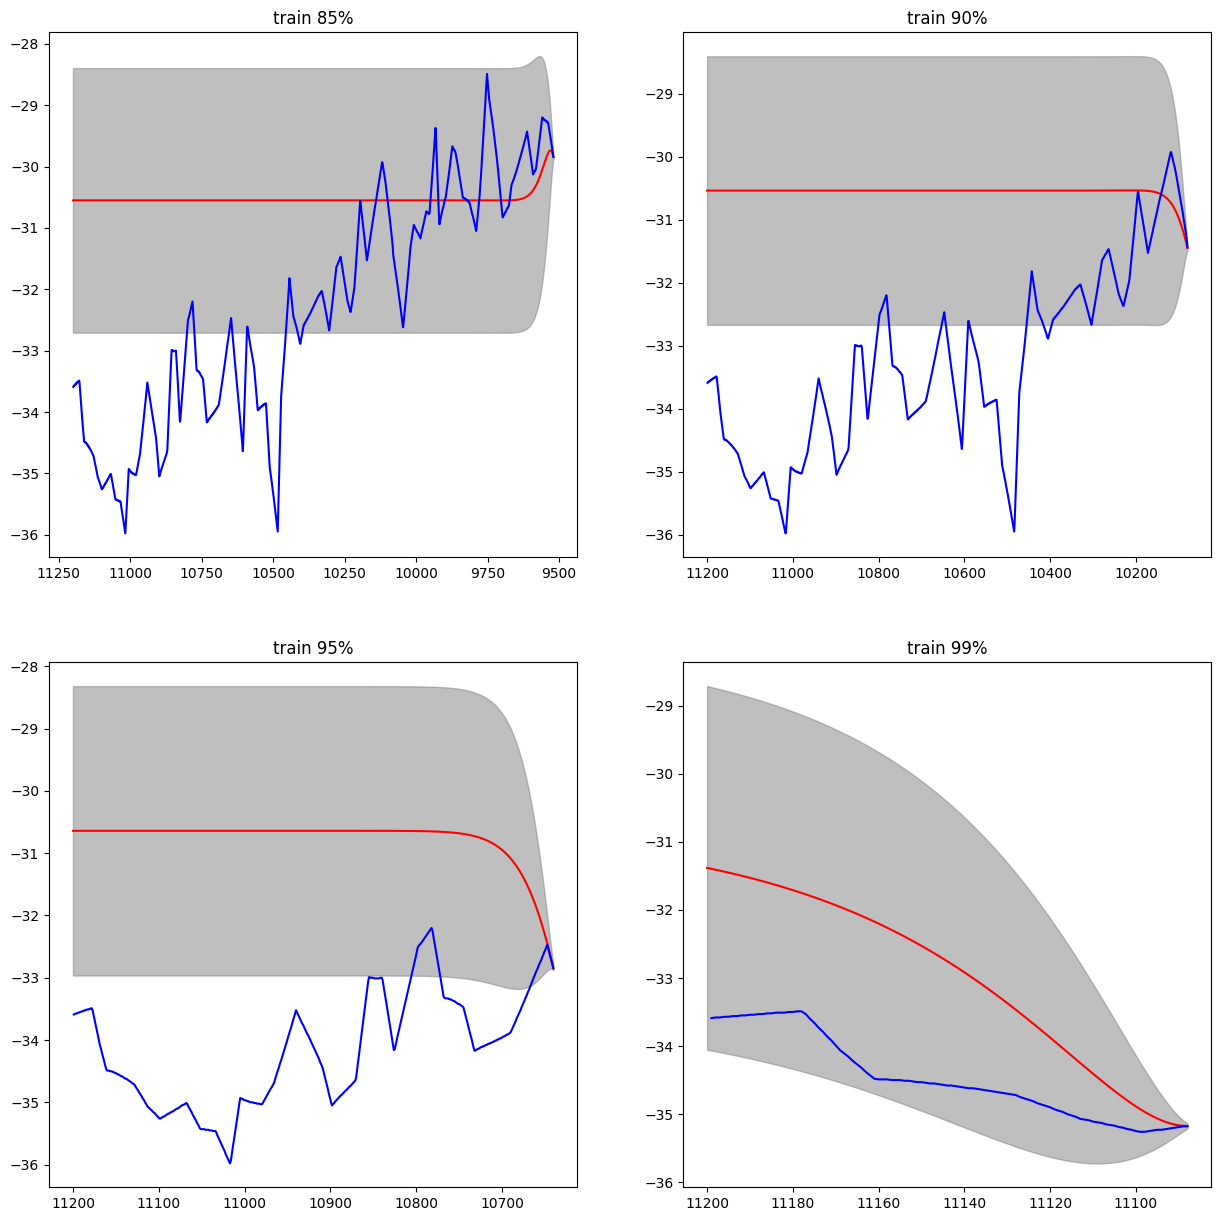

In [28]:
# create a list of subplot positions
positions = [(0,0), (0,1), (1,0), (1,1)]
mse_l = []
rmse_l = []
aic_l = []
bic_l = []
r2_l = []
# create a figure and subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

# loop over the positions and plot the data
for i, pos in enumerate(positions):
    t_value = int(len(series)*(percentage[i]/100))
    row, col = pos
    ax = axs[row][col]
    train= series[0:t_value]
    test= series[t_value:]
    model = sm.tsa.ARIMA(train, order=(2,0,0))
    results = model.fit()
    # In-sample one-step-ahead predictions
    predict = results.get_prediction(start=len(train), end=11200)
    predict_ci = predict.conf_int()
    predict_dy = results.predict(start=len(train), end=11200)
    range_ffd = len(test)
    mse = mean_squared_error(test[:range_ffd], predict_dy[:range_ffd]) #MSE
    mse_l.append(round(mse,2))
    rmse = math.sqrt(mse) #RMSE
    rmse_l.append(round(rmse,2))
    aic = calculate_aic(len(test[:range_ffd]), mse,2)  #AIC
    aic_l.append(round(aic,2))
    bic = calculate_bic(len(test[:range_ffd]), mse,2)  #BIC
    bic_l.append(round(bic,2))
    r2_pred = r2_score(test[:range_ffd], predict_dy[:range_ffd])  #R2
    r2_l.append(round(r2_pred,2))
    
    ax.plot(predict_dy,color='red')
    ax.plot(test,color='blue')
    ax.fill_between(range(len(train),11200+1), predict_ci.iloc[:,0], 
                    predict_ci.iloc[:,1], alpha=0.5, color='gray', label='95% Confidence')
    ax.set_title(f"train {percentage[i]}%")
    ax.invert_xaxis()
#plt.savefig("Final_figure/AR(2)_multi_test.svg")
plt.show()

In [30]:
import pandas as pd

# Create a DataFrame
df = pd.DataFrame({'MSE': mse_l, 'RMSE': rmse_l, 'AIC': aic_l, 'BIC': bic_l, "R-Squared": r2_l})

# Change the row index
df.index = ['Train 85%', 'Train 90%', 'Train 95%', 'Train 99%']  # Assign new row index values

# Print the DataFrame
print(df)


             MSE  RMSE      AIC      BIC  R-Squared
Train 85%   6.63  2.57  3181.62  3192.48      -0.88
Train 90%   9.70  3.11  2548.69  2558.73      -3.82
Train 95%  12.74  3.57  1429.14  1437.80     -14.91
Train 99%   2.59  1.61   110.63   116.06      -6.16


In [31]:
## ARMA(3,5) Model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(3,0,5))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     Greenland_temperature   No. Observations:                11088
Model:                    ARIMA(3, 0, 5)   Log Likelihood               28426.823
Date:                   Thu, 01 Jun 2023   AIC                         -56833.646
Time:                           09:14:55   BIC                         -56760.510
Sample:                                0   HQIC                        -56809.017
                                 - 11088                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.7802      0.173   -177.409      0.000     -31.120     -30.440
ar.L1          2.5011      0.194     12.888      0.000       2.121       2.881
ar.L2         -2.0377      0.374     -5.445      0.000      -2.771      -1.304
ar.L3          0.5360      0.180      2.971      0.003       0.182       0.890
ma.L1         -0.6841      0.195     -3.515      0.000      -1.065      -0.303
ma.L2          0.0960      0.022      4.328      0.000       0.053       0.140
ma.L3          0.0215      0.015      1.415      0.157      -0.008       0.051
ma.L4         -0.0342      0.012     -2.738      0.006      -0.059      -0.010
ma.L5          0.0520      0.010      5.067      0.000       0.032       0.072
sigma2         0.0003   7.16e-07    484.212      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):         112237745.17
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             2.56
Prob(H) (two-sided):                  0.00   Kurtosis:                       495.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
import pandas as pd
df = pd.DataFrame({"Greenland_temperature":series})
df_new = df
for i in range(10):
    # Shift the DataFrame forward by one period
    df_shifted = df.shift(periods=i+1)
    df_shifted.rename(columns={'Greenland_temperature': 'x'+str(i)})
    df_new = pd.concat([df_shifted,df_new], axis=1)
# Print the original and shifted DataFrames
df_new.rename(columns={'Greenland_temperature': 'x1', 'Greenland_temperature': 'x2',
                       'Greenland_temperature': 'x3','Greenland_temperature': 'x4',
                       'Greenland_temperature': 'x5','Greenland_temperature': 'x6'
                       ,'Greenland_temperature': 'x7','Greenland_temperature': 'x8',
                       'Greenland_temperature': 'x9','Greenland_temperature': 'x10'})
df_new.columns = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','y']
v = sum(df_new['x1'].isnull())
df_new = df_new.iloc[v:,[0,10]]
df_new

,x1,y
10,-30.54,-31.73
11,-30.61,-31.78
12,-30.72,-31.80
13,-30.85,-31.84
14,-31.02,-31.86
...,...,...
11195,-33.52,-33.57
11196,-33.52,-33.57
11197,-33.53,-33.58
11198,-33.53,-33.58


In [33]:
## data splitted into 80-20 percentage
from sklearn.model_selection import train_test_split
x = df_new.iloc[:,[0]]
y = df_new.iloc[:,1]
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2,shuffle=False)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((8952, 1), (2238, 1), (8952,), (2238,))

In [34]:
from sklearn.linear_model import LinearRegression
# Create a linear regression model and fit the data
model = LinearRegression().fit(xtrain, ytrain)

print(model.intercept_, model.coef_)

y_pred = model.predict(xtest)

-2.363141670240733 [0.92268474]


In [35]:
print(model.intercept_, model.coef_, model.score(xtrain, ytrain))

-2.363141670240733 [0.92268474] 0.8515050253696979


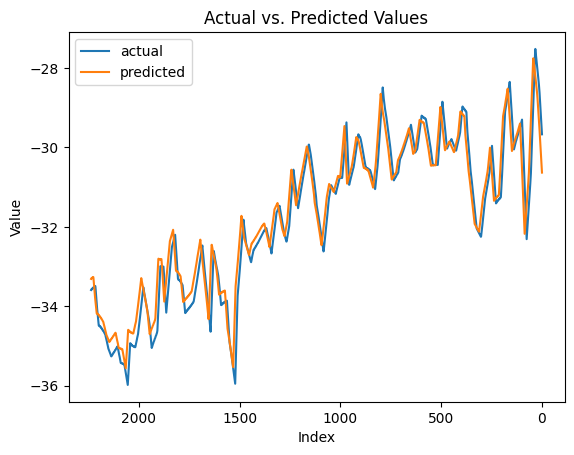

In [37]:
import matplotlib.pyplot as plt

index = range(len(ytest))
# Actual values
actual = ytest

# Predicted values
predicted = y_pred

# Create a figure and axis object
plt.plot(index,actual, label = "actual")
plt.plot(index,predicted, label = "predicted")


# Set plot title and labels
plt.title('Actual vs. Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')

# Add legend
plt.legend()
plt.gca().invert_xaxis()
#plt.savefig("Final_figure/linear_reg.svg")

# Display plot
plt.show()

In [39]:
mse = mean_squared_error(actual, predicted)
print('MSE: %.3f' % mse)
# calculate the aic
aic = calculate_aic(len(actual), mse,2)
print('AIC: %.3f' % aic)
# calculate the aic
bic = calculate_bic(len(actual), mse,2)
print('BIC: %.3f' % bic)
# Return the square root 
print ('RMSE: %.3f' % math.sqrt(mse))
# Calculate R-squared predicted
r2_pred = r2_score(actual, predicted)

print("R-squared predicted:", round(r2_pred,2))

MSE: 0.218
AIC: -3409.753
BIC: -3398.326
RMSE: 0.466
R-squared predicted: 0.94


In [ ]:
import pandas as pd

# Existing DataFrame
accuracy_df = pd.DataFrame({'r2': [], 'mse': [],'rmse': [], 'AIC': [],'BIC': []})
accuracy_df

In [ ]:
new_value = {'r2': r2_pred, 'mse': mse,'rmse': math.sqrt(mse), 'AIC': aic,'BIC': bic}

# Append the value to the DataFrame
accuracy_df = pd.concat([accuracy_df, pd.DataFrame([new_value])], ignore_index=True)

# Print the updated DataFrame
print(accuracy_df)